In [6]:
!pip install scikit-learn==1.5.2

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# For nice plots
sns.set(style="whitegrid", context="notebook")

In [8]:
url = "https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv"
housing = pd.read_csv(url)
print("Data shape:", housing.shape)
housing.head()

Data shape: (20000, 21)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0


In [9]:
# Check missing values
print("\nMissing values per column:")
print(housing.isnull().sum())

# Create new date-based features (if 'date' column exists)
if 'date' in housing.columns:
    housing['date'] = pd.to_datetime(housing['date'])
    housing['sale_year'] = housing['date'].dt.year
    housing['sale_month'] = housing['date'].dt.month
    housing = housing.drop(columns=['date'])

# Drop rows with missing target
housing = housing.dropna(subset=['price'])

# Identify numeric and categorical columns
num_cols = housing.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = housing.select_dtypes(exclude=[np.number]).columns.tolist()

# Fill numeric NaNs with median
housing[num_cols] = housing[num_cols].fillna(housing[num_cols].median())

# One-hot encode categorical features
housing = pd.get_dummies(housing, columns=cat_cols, drop_first=True)


Missing values per column:
id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64


In [10]:
X = housing.drop('price', axis=1)
y = housing['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [11]:
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=200, random_state=42)

In [12]:
y_pred = gbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel performance on test set:")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE:  {mae:,.2f}")
print(f"R²:   {r2:.4f}")


Model performance on test set:
RMSE: 123,405.02
MAE:  70,172.03
R²:   0.8990


/tmp/ipython-input-2188711020.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis')


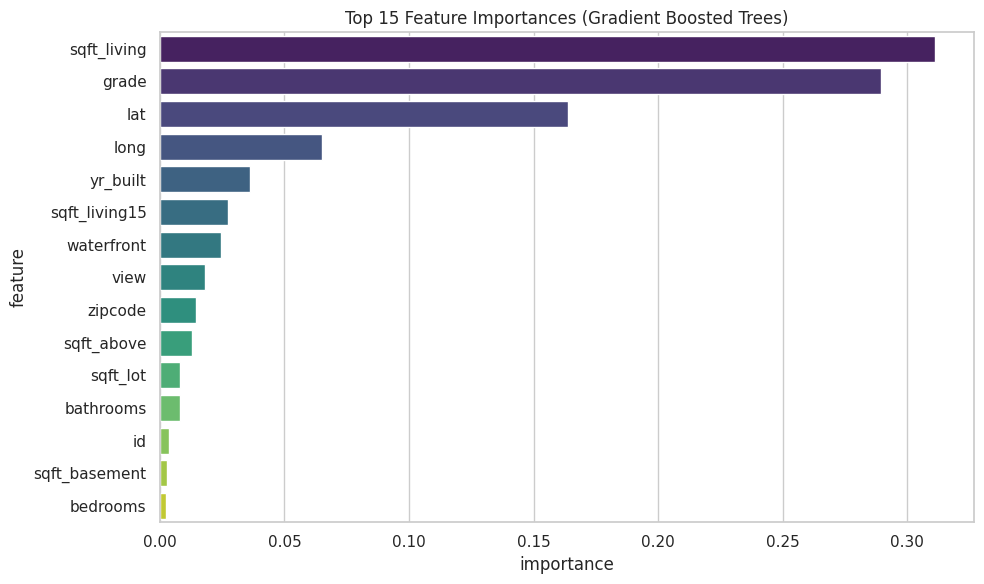

In [13]:
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': gbr.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis')
plt.title("Top 15 Feature Importances (Gradient Boosted Trees)")
plt.tight_layout()
plt.show()

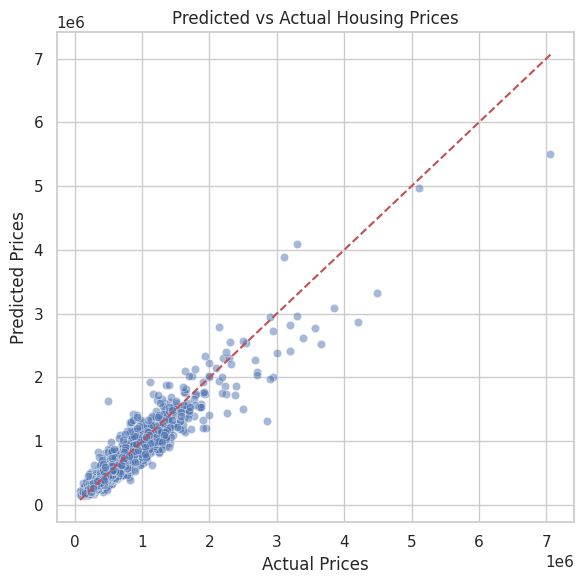

In [14]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Housing Prices")
plt.tight_layout()
plt.show()

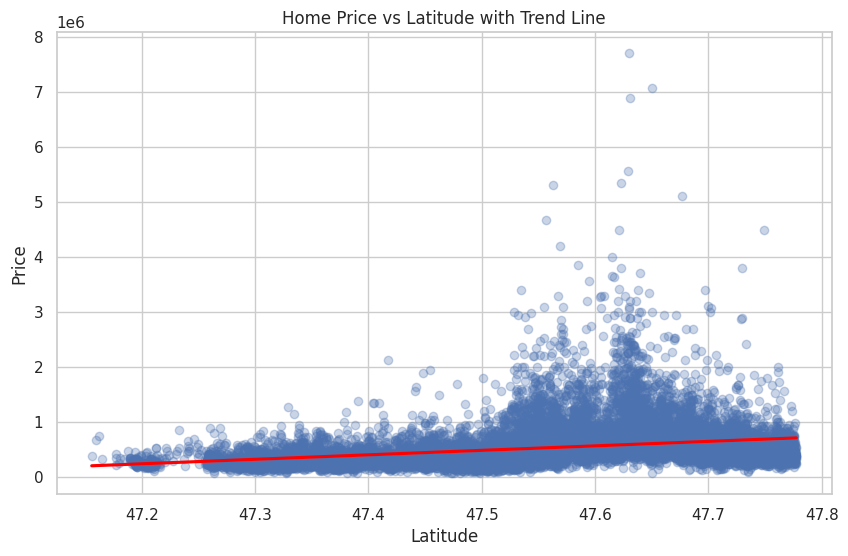

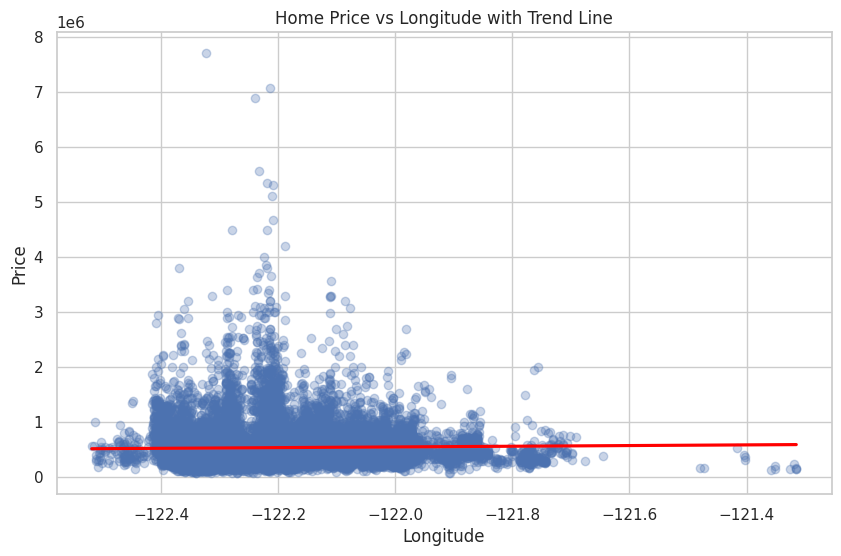

In [23]:
plt.figure(figsize=(10,6))
sns.regplot(data=housing, x='lat', y='price', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Home Price vs Latitude with Trend Line")
plt.xlabel("Latitude")
plt.ylabel("Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
sns.regplot(data=housing, x='long', y='price', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Home Price vs Longitude with Trend Line")
plt.xlabel("Longitude")
plt.ylabel("Price")
plt.grid(True)
plt.show()

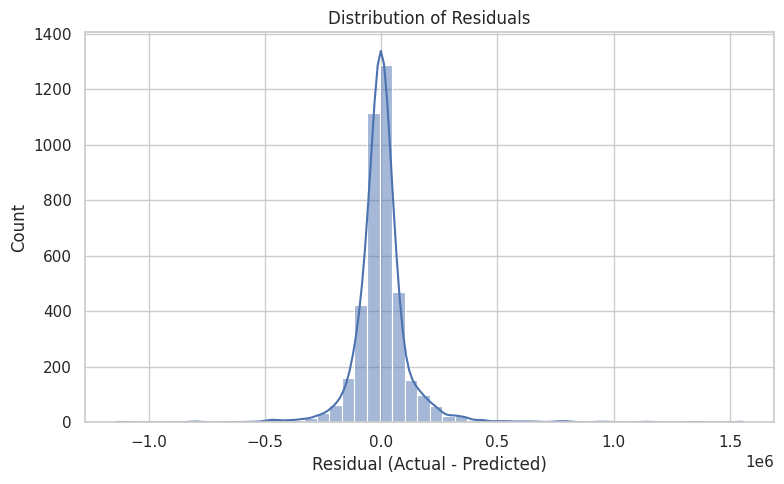

In [15]:
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-4111501206.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=housing, x='waterfront', y='price', palette="coolwarm")


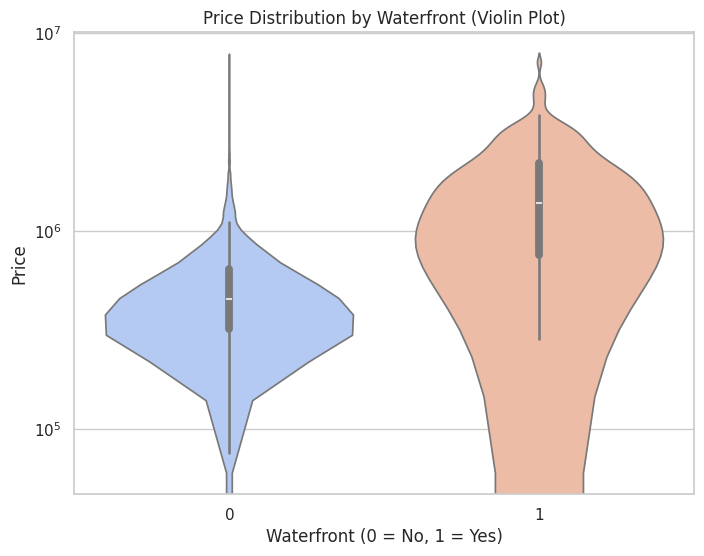

Estimated effect of Waterfront on price: $1,101,164.44
Base price (intercept): $531,122.92
R^2 of Waterfront model: 0.0677


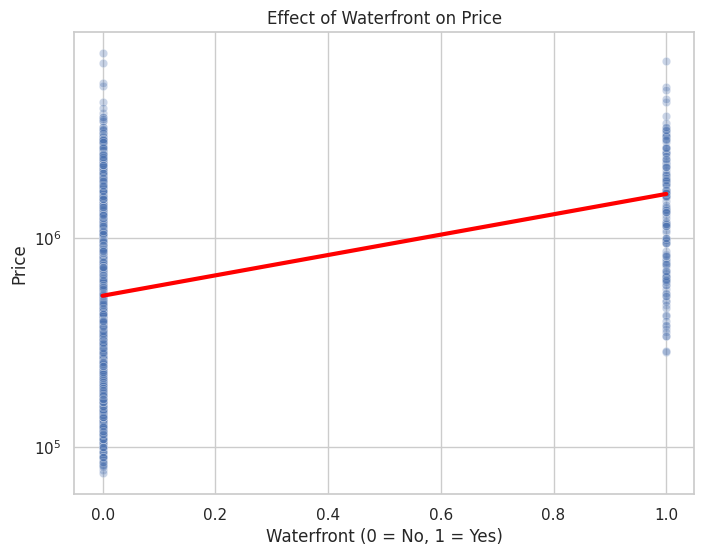

In [27]:
plt.figure(figsize=(8,6))
sns.violinplot(data=housing, x='waterfront', y='price', palette="coolwarm")
plt.title("Price Distribution by Waterfront (Violin Plot)")
plt.xlabel("Waterfront (0 = No, 1 = Yes)")
plt.ylabel("Price")
plt.yscale('log')
plt.show()

# --- Simple Regression Model ---
X = housing[['waterfront']]
y = housing['price']

model = LinearRegression()
model.fit(X, y)

waterfront_effect = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

print(f"Estimated effect of Waterfront on price: ${waterfront_effect:,.2f}")
print(f"Base price (intercept): ${intercept:,.2f}")
print(f"R^2 of Waterfront model: {r2:.4f}")

# --- Scatter plot with regression line ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=housing, x='waterfront', y='price', alpha=0.3)
sns.lineplot(x=[0,1], y=[intercept, intercept+waterfront_effect], color='red', linewidth=3)
plt.title("Effect of Waterfront on Price")
plt.xlabel("Waterfront (0 = No, 1 = Yes)")
plt.ylabel("Price")
plt.yscale('log')
plt.grid(True)
plt.show()

/tmp/ipython-input-1227669650.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=housing, x='grade', y='price', palette='coolwarm')


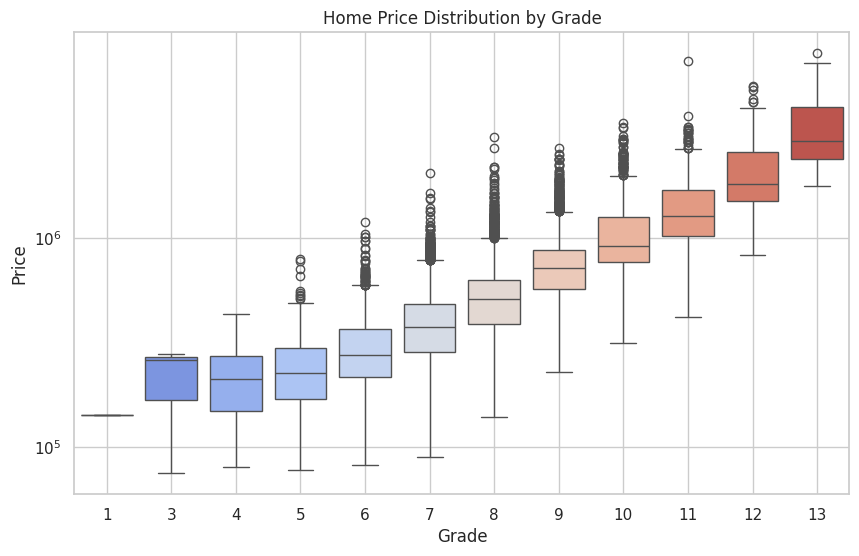

/tmp/ipython-input-1227669650.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_price_by_grade, x='grade', y='price', palette='viridis')


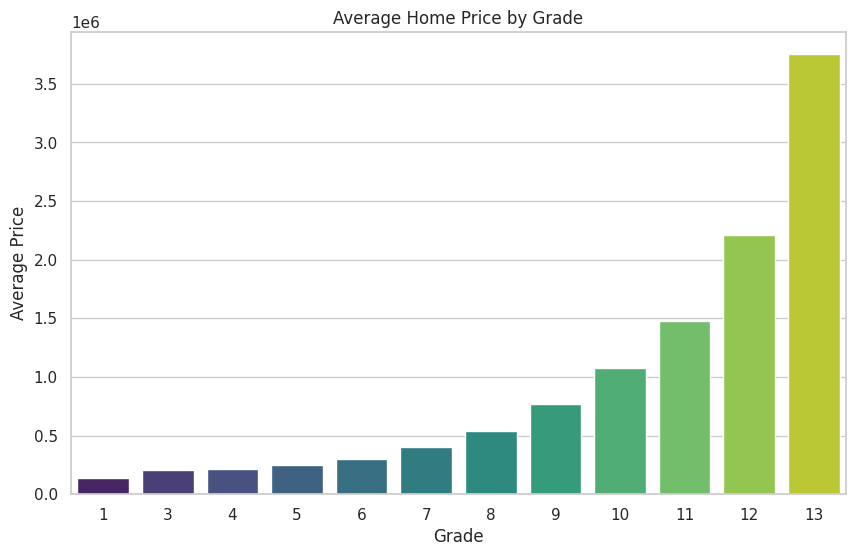

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(data=housing, x='grade', y='price', palette='coolwarm')
plt.title("Home Price Distribution by Grade")
plt.xlabel("Grade")
plt.ylabel("Price")
plt.yscale('log')  # log scale to handle very expensive homes
plt.grid(True)
plt.show()

# ---  Average price by grade ---
avg_price_by_grade = housing.groupby('grade')['price'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=avg_price_by_grade, x='grade', y='price', palette='viridis')
plt.title("Average Home Price by Grade")
plt.xlabel("Grade")
plt.ylabel("Average Price")
plt.show()